<a href="https://colab.research.google.com/github/jusscarrascosa/ProyectoKairos/blob/main/Simulaci%C3%B3n_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# utilidades para estructura y logging
from dataclasses import dataclass, field
from typing import List, Dict, Callable, Any, Optional
from collections import deque
import logging
import json
import time
import random

# imports opcionales (no fallan si no están instalados; los usaremos si están disponibles)
try:
    import simpy   # simulación de eventos discretos (opcional)
except Exception:
    simpy = None

try:
    from tqdm import tqdm  # barra de progreso (opcional)
except Exception:
    tqdm = None

try:
# si querés usar una implementación de Kalman ya hecha\n",
    from filterpy.kalman import KalmanFilter
except Exception:
    KalmanFilter = None

# configuración reproducible y de estilo de gráficas (como en tu código)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "figure.figsize": (10, 4),
    "lines.linewidth": 2,
})

In [ ]:
# ==== RESILIENCIA KAIROS: setup global ====
from resiliencia_kairos import (
    TimeAuthority, resample_align, HybridWatermarkBuffer,
    SnapshotCatalog, kpi_valid_rate, kpi_mttr, kpi_state_ratios, kpi_cri, kpi_hash_integrity
)
import pandas as pd, time

TA = TimeAuthority(window=400)
_BASES = {}  # sid -> {"ref0": float, "dev0": float}

def corregir_timestamp(packet: dict, sensor_id: str):
    """
    Corrige offset y deriva usando tiempos RELATIVOS por sensor y
    reconstruye el tiempo corregido absoluto. Agrega:
      - packet['time_corr'] (float epoch)
      - packet['time_corr_ts'] (pandas.Timestamp)
    """
    t_ref_abs = time.time()
    raw = packet.get("time", t_ref_abs)
    if isinstance(raw, pd.Timestamp):
        t_dev_abs = raw.timestamp()
    elif isinstance(raw, (int, float)):
        t_dev_abs = float(raw)
    else:
        t_dev_abs = pd.to_datetime(raw).timestamp()

    if sensor_id not in _BASES:
        _BASES[sensor_id] = {"ref0": t_ref_abs, "dev0": t_dev_abs}

    ref0 = _BASES[sensor_id]["ref0"]
    dev0 = _BASES[sensor_id]["dev0"]

    # trabajar en relativo para evitar offsets astronómicos
    t_ref_rel = t_ref_abs - ref0
    t_dev_rel = t_dev_abs - dev0

    TA.update(sensor_id, t_dev_rel, t_ref_rel)
    t_corr_rel = TA.correct(sensor_id, t_dev_rel)
    t_corr_abs = ref0 + t_corr_rel

    packet["time_corr"] = t_corr_abs
    packet["time_corr_ts"] = pd.to_datetime(t_corr_abs, unit="s")
    return packet
# ==== fin setup ====


In [ ]:
# ==== snapshots / auditoría (Kairos) ====
CAT = SnapshotCatalog(root="/mnt/data/state_store")

# guardaremos el último deploy_id para poder volver atrás
last_deploy_id = None

def snapshot_model(model_obj, cfg_dict, metrics_dict):
    global last_deploy_id
    meta = CAT.create(artifact=model_obj, config=cfg_dict, metrics=metrics_dict)
    last_deploy_id = meta.deploy_id
    print("[Snapshot] deploy_id:", meta.deploy_id)
    return meta.deploy_id

def rollback_to(deploy_id):
    artifact, cfg, met, meta_info = CAT.load(deploy_id)
    print("[Rollback] restaurado", deploy_id)
    return artifact, cfg, met
# ==== fin snapshots ====


# Planta Real

## Definicion del entorno fisico

In [ ]:
def generate_real_signals(t):
    temp = 20 + 5*np.sin(0.05*t) + np.random.normal(0, 3)
    solar_rad = max(0, 800*np.sin(0.1*t)) + np.random.normal(0, 20)
    solar_rad = max(0, solar_rad)  # <-- añade esta línea
    humidity = 50 + 10*np.sin(0.02*t) + np.random.normal(0, 1)
    pressure = 1013 + 5*np.sin(0.01*t) + np.random.normal(0, 5)
    wind = 5 + 2*np.sin(0.07*t) + np.random.normal(0, 2)
    grid_available = 1 if np.random.rand() > 0.01 else 0
    return {"temp": temp, "solar_rad": solar_rad, "humidity": humidity,
            "pressure": pressure, "wind": wind, "grid": grid_available}

## Sensores

In [ ]:
@dataclass
class Sensor:
    name: str
    noise_std: float
    bias: float = 0.0
    missing_prob: float = 0.0  # probabilidad de fallo

    def read(self, true_value):
        if np.random.rand() < self.missing_prob:
            return None  # fallo de lectura
        noisy_value = true_value + self.bias + np.random.normal(0, self.noise_std)
        return noisy_value

# Sensores definidos
termocupla1 = Sensor("TC1", noise_std=0.5)
termocupla2 = Sensor("TC2", noise_std=0.7, bias=0.2)
termocupla3 = Sensor("TC3", noise_std=0.6)

infrarrojo1 = Sensor("IR1", noise_std=1.5)
infrarrojo2 = Sensor("IR2", noise_std=1.2, bias=-0.5)
infrarrojo3 = Sensor("IR3", noise_std=1.0)


In [ ]:
class PlausibilityFilter:
    def __init__(self, min_val: float, max_val: float):
        self.min_val = min_val
        self.max_val = max_val

    def check(self, value) -> float:
        # Soporta float, numpy.float64, None, etc.
        import pandas as _pd
        import numpy as _np
        if value is None or _pd.isna(value):
            return _np.nan
        if value < self.min_val or value > self.max_val:
            return _np.nan
        return float(value)


##Estacion Meteorologica

In [ ]:
est_temp = Sensor("EstTemp", noise_std=0.3)
est_hum = Sensor("EstHum", noise_std=1.0)
est_press = Sensor("EstPress", noise_std=0.5)


## Generacion de Energia

In [ ]:
@dataclass
class SolarPanel:
    area: float  # m²
    efficiency: float  # 0–1

    def generate(self, solar_rad):
        return self.area * self.efficiency * solar_rad / 1000  # kW aprox

@dataclass
class WindTurbine:
    k: float
    p_max: float

    def generate(self, wind_speed):
        power = self.k * (wind_speed**3)
        return min(power, self.p_max)

@dataclass
class Battery:
    capacity: float  # kWh
    soc: float = 0.5  # estado de carga inicial [0–1]

    def charge(self, power_in, dt=1):
        self.soc = min(1.0, self.soc + (power_in/self.capacity)*dt)

    def discharge(self, power_out, dt=1):
        self.soc = max(0.0, self.soc - (power_out/self.capacity)*dt)

    def get_energy(self):
        return self.capacity * self.soc


##Simulacion del entorno

In [ ]:
solar = SolarPanel(area=10, efficiency=0.18)  # área 10 m², eficiencia 18% preguntarle a bauti
turbina = WindTurbine(k=0.05, p_max=5)        # curva simple, límite 5 kW bauti
bateria = Battery(capacity=20)                # batería de 20 kWh bauti

# Eficiencias de carga/descarga
eta_carga = 0.95
eta_descarga = 0.9

# Tiempo de simulación (24 h, paso de 1 min)
dt = 1  # minutos
T_sim = 24 * 60
t_grid = np.arange(0, T_sim, dt)  # vector de tiempos de simulación

# Log para guardar resultados
log = {
    "time": [],
    "temp": [],
    "solar_rad": [],
    "wind": [],
    "grid": [],
    "panel": [],
    "turbina": [],
    "demanda": [],
    "balance": [],
    "soc": []
}
#Loop de simulcion
for t in t_grid:
    # --- 1. Generar señales reales de la planta
    signals = generate_real_signals(t)

    # --- 2. Leer sensores
    temp = termocupla1.read(signals["temp"])
    solar_rad = infrarrojo1.read(signals["solar_rad"])
    wind = est_temp.read(signals["wind"])  # ojo: podés definir sensor específico para viento
    grid = signals["grid"]

    # --- 3. Generación solar y eólica
    panel_power = solar.generate(solar_rad if solar_rad else 0)
    turbina_power = turbina.generate(wind if wind else 0)
    generacion = panel_power + turbina_power

    # --- 4. Demanda (más alta de noche, más baja de día)
    hora = (t % 1440) / 60
    if 0 <= hora < 6 or 20 <= hora < 24:
        demanda = 3.0  # kW
    else:
        demanda = 1.5  # kW

    # --- 5. Balance neto
    balance = generacion - demanda

    # --- 6. Actualizar batería
    if balance >= 0:  # sobra energía → carga
        bateria.charge(balance * eta_carga * (dt/60))
    else:  # falta energía → descarga
        bateria.discharge(-balance / eta_descarga * (dt/60))

    # --- 7. Guardar en log
    log["time"].append(t)
    log["temp"].append(temp)
    log["solar_rad"].append(solar_rad)
    log["wind"].append(wind)
    log["grid"].append(grid)
    log["panel"].append(panel_power)
    log["turbina"].append(turbina_power)
    log["demanda"].append(demanda)
    log["balance"].append(balance)
    log["soc"].append(bateria.soc)

# Convertimos log a DataFrame
auditoriadelentorno = pd.DataFrame(log)
print(auditoriadelentorno.head())

   time       temp   solar_rad      wind  grid     panel   turbina  demanda  \
0     0  21.373074   -0.871317  4.374142     1 -0.001568  4.184550      3.0   
1     1  21.132906   40.656916  3.293540     1  0.073182  1.786318      3.0   
2     2  18.720172  160.353443  4.076150     1  0.288636  3.386263      3.0   
3     3  23.313256  212.327250  3.025076     1  0.382189  1.384136      3.0   
4     4  21.174963  306.385784  4.897758     1  0.551494  5.000000      3.0   

    balance       soc  
0  1.182981  0.500937  
1 -1.140500  0.499881  
2  0.674899  0.500415  
3 -1.233675  0.499273  
4  2.551494  0.501292  


#Proteccion de Datos

In [ ]:
import hashlib, json
from datetime import datetime

def _serialize_for_hash(x):
    import numpy as _np
    import pandas as _pd
    if isinstance(x, (_np.floating, _np.integer)):
        return x.item()                      # convierte numpy a Python nativo
    if isinstance(x, _pd.Timestamp):
        return x.isoformat()                 # timestamp a ISO8601
    if isinstance(x, (datetime, )):
        return x.isoformat()
    return x

def generar_hash(paquete: dict) -> str:
    # excluimos cualquier hash previo para evitar auto-referencia
    data = {k: v for k, v in paquete.items() if k != "hash"}
    # saneo recursivo para json.dumps
    def _clean(o):
        if isinstance(o, dict):
            return {k: _clean(v) for k, v in o.items()}
        if isinstance(o, list):
            return [_clean(v) for v in o]
        return _serialize_for_hash(o)
    clean = _clean(data)
    payload = json.dumps(clean, sort_keys=True, ensure_ascii=False).encode()
    return hashlib.sha256(payload).hexdigest()

def verificar_hash(paquete: dict) -> bool:
    hash_guardado = paquete.get("hash", "")
    paquete_sin_hash = {k: v for k, v in paquete.items() if k != "hash"}
    return hash_guardado == generar_hash(paquete_sin_hash)


#Nodo de Integracion

In [ ]:
# -------------------------
# INTEGRATION NODE con filtros
# -------------------------
class IntegrationNode:
    """
    Toma las funciones/objetos de la Planta Real (generate_real_signals,
    sensores, panel, turbina, bateria) y entrega un paquete unificado por t.
   Incluye:
    - Plausibility filter por cada sensor
    - Kalman filter (si filterpy está disponible)
    """

    generate_fn: Callable[[float], Dict[str, float]]
    sensors: Dict[str, Any]                 # nombre -> Sensor instance
    solar_panel: Optional[Any] = None
    wind_turbine: Optional[Any] = None
    battery: Optional[Any] = None
    eta_carga: float = 0.95
    eta_descarga: float = 0.9

    def __init__(self, generate_fn, sensors, solar_panel=None, wind_turbine=None, battery=None, eta_carga: float = 0.95, eta_descarga: float = 0.9):
        self.generate_fn = generate_fn
        self.sensors = sensors
        self.solar_panel = solar_panel
        self.wind_turbine = wind_turbine
        self.battery = battery
        self.eta_carga = eta_carga
        self.eta_descarga = eta_descarga

        # Creamos un filtro de plausibilidad por sensor (ajustar rangos a tu caso real)
        default_ranges = {
            "temp": (-20, 60),
            "solar_rad": (0, 1200),
            "humidity": (0, 100),
            "pressure": (900, 1100),
            "wind": (0, 40),
        }
        self.plausibility_filters = {}
        for name in sensors.keys():
            mn, mx = default_ranges.get(name, (-1e9, 1e9))
            self.plausibility_filters[name] = PlausibilityFilter(min_val=mn, max_val=mx)


        # Creamos un filtro de Kalman por sensor si está disponible
        self.kalman_filters = {}
        if KalmanFilter is not None:
            for name in sensors.keys():
                kf = KalmanFilter(dim_x=1, dim_z=1)
                kf.x = np.array([[0.]])            # estado inicial
                kf.F = np.array([[1.]])            # matriz de transición
                kf.H = np.array([[1.]])            # matriz de observación
                kf.P *= 10.                        # incertidumbre inicial
                kf.R = 5.                          # varianza de medición
                kf.Q = 0.01                        # ruido del proceso
                self.kalman_filters[name] = kf
    def read_step(self, t: float, demanda_kw: float = 3.0) -> Dict[str, Any]:
        # 1) valores "verdaderos"
        true = self.generate_fn(t)

        # 2) sensores + filtros
        readings = {}
        for name, sensor in self.sensors.items():
            raw_val = sensor.read(true.get(name, np.nan))
            plausible_val = self.plausibility_filters[name].check(raw_val)
            if not np.isnan(plausible_val) and name in self.kalman_filters:
                kf = self.kalman_filters[name]; kf.predict(); kf.update(plausible_val)
                kalman_val = float(kf.x[0])
            else:
                kalman_val = np.nan
            readings[name] = {"raw": raw_val, "plausible": plausible_val, "kalman": kalman_val}

        # 3) generación renovable
        panel_kw = self.solar_panel.generate(true.get("solar_rad", 0.0)) if self.solar_panel else 0.0
        turbine_kw = self.wind_turbine.generate(true.get("wind", 0.0)) if self.wind_turbine else 0.0

        # 4) balance
        generation_kw = panel_kw + turbine_kw
        balance_kw = generation_kw - demanda_kw

        # 5) batería
        soc_before = self.battery.soc if self.battery else None
        if self.battery is not None:
            if balance_kw > 0:
                self.battery.charge(balance_kw * self.eta_carga, dt=1)
            else:
                self.battery.discharge((-balance_kw) / self.eta_descarga, dt=1)
            soc_after = self.battery.soc
        else:
            soc_after = None

        # 6) empaquetar
        sensor_id_ref = next(iter(self.sensors.keys())) if self.sensors else "INTEGRATION"
        packet = {
            "sensor_id": sensor_id_ref,
            "time": t,                 # timestamp crudo (simulado)
            "true": true,
            "sensor_readings": readings,
            "panel_kw": panel_kw,
            "turbine_kw": turbine_kw,
            "generation_kw": generation_kw,
            "demanda_kw": demanda_kw,
            "balance_kw": balance_kw,
            "soc_before": soc_before,
            "soc_after": soc_after,
        }

        # 6b) corregir tiempo (añade time_corr / time_corr_ts)
        packet = corregir_timestamp(packet, packet["sensor_id"])

        # 6c) hash DESPUÉS de corregir (auditoría consistente)
        packet["hash"] = generar_hash(packet)

        return packet

In [ ]:
packet_test = {"sensor_id": "S1", "time": 1000.0}
packet_test = corregir_timestamp(packet_test, packet_test["sensor_id"])
print(packet_test)

{'sensor_id': 'S1', 'time': 1000.0, 'time_corr': 1759196892.9034693, 'time_corr_ts': Timestamp('2025-09-30 01:48:12.903469324')}


In [ ]:
print("Δt = corr - crudo:", packet_test["time_corr"] - float(packet_test["time"]))

Δt = corr - crudo: 1759195892.9034693


In [ ]:
packet_test["time_corr"]  # en lugar de packet["time"]

1759196892.9034693

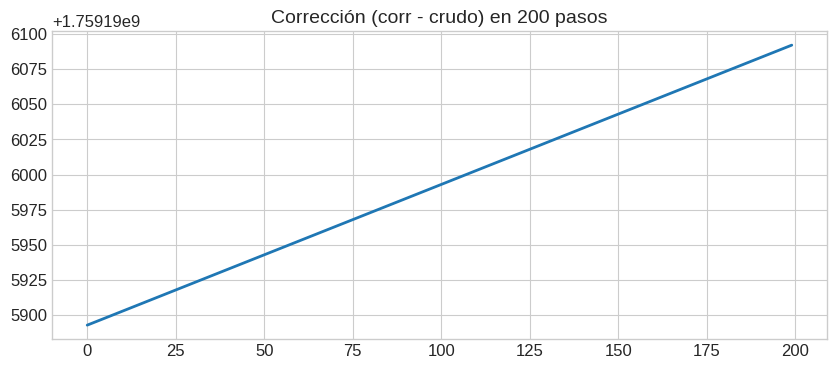

In [ ]:
deltas = []
for i in range(200):
    pkt = {"sensor_id": "S1", "time": 1000.0 + i*1.001}  # metemos un drift artificial
    pkt = corregir_timestamp(pkt, pkt["sensor_id"])
    deltas.append(pkt["time_corr"] - float(pkt["time"]))

plt.plot(deltas)
plt.title("Corrección (corr - crudo) en 200 pasos")
plt.show()

In [ ]:
# Sensores en diccionario
sensores = {
    "temp": termocupla1,        # ← variable de generate_real_signals
    "solar_rad": infrarrojo1,   # ← variable de generate_real_signals
    "wind": est_temp,           # ← variable de generate_real_signals
    "humidity": est_hum,        # opcional
    "pressure": est_press       # opcional
}


# Nodo de integración
integration_node = IntegrationNode(
    generate_fn=generate_real_signals,
    sensors=sensores,
    solar_panel=solar,
    wind_turbine=turbina,
    battery=bateria,
    eta_carga=eta_carga,
    eta_descarga=eta_descarga
)
integration_node.plausibility_filters = {
    "temp":       PlausibilityFilter(-20, 60),
    "solar_rad":  PlausibilityFilter(0, 1200),
    "humidity":   PlausibilityFilter(0, 100),
    "pressure":   PlausibilityFilter(900, 1100),  # CLAVE
    "wind":       PlausibilityFilter(0, 40),
}


##Gemelos

In [ ]:
class Gemelo:
    def __init__(self, name, model):
        self.name = name
        self.model = model

    def entrenar(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Pipeline

In [ ]:
# ----------------------
# PIPELINE CON MÉTRICAS DE CONFIANZA
# ----------------------
from collections import deque
from typing import Callable, Dict, Any, Optional, Tuple
import copy
import numpy as np

class ClockedPipeline:
    """
    Pipeline con reloj virtual. Etapas: IF -> ID -> EX -> MEM -> WB
    Implementa bancos de registro entre las etapas (IF_ID, ID_EX, EX_MEM, MEM_WB).
    Permite:
        - insertar burbujas (bubbles)
        - recolectar métricas de confianza
        - integración con un shadow validator
    Métricas exportadas:
        - skew_avg: error medio de estimación
        - drift: desviación estándar del error
        - bubble_ratio: porcentaje de burbujas generadas
        - lateness_avg: edad promedio de los datos procesados
    """
    STAGES = ["IF","ID","EX","MEM","WB"]
    REG_PAIRS = { "IF":"IF_ID", "ID":"ID_EX", "EX":"EX_MEM", "MEM":"MEM_WB" }

    def __init__(self,
                 stage_handlers: Dict[str, Callable[[Dict[str, Any]], Optional[Dict[str, Any]]]],
                 latencies: Optional[Dict[str, int]] = None,
                 watermark_delay: int = 0,
                 policy: str = "wait",
                 insert_bubbles: bool = False,
                 shadow_validator: Optional[Callable[[Dict[str, Any]], Tuple[bool, Any]]] = None):
        self.stage_handlers = stage_handlers
        self.latencies = latencies or {s:1 for s in self.STAGES}
        self.watermark_delay = watermark_delay
        assert policy in ("wait","realtime")
        self.policy = policy
        self.insert_bubbles = insert_bubbles
        self.shadow_validator = shadow_validator

        self.in_queue = deque()
        self.registers = { "IF_ID": None, "ID_EX": None, "EX_MEM": None, "MEM_WB": None }
        self.stage_state = {
            s: {"busy": False, "remaining": 0, "packet": None, "completed_waiting": False}
            for s in self.STAGES
        }

        self.state_db = {}
        self.completed = []
        self.trace = []
        self.virtual_time = 0

        # --- métricas ---
        self.metric_skew = []       # diferencias entre predicho y real
        self.metric_drift = []      # desviación estándar del error
        self.metric_bubbles = 0     # burbujas totales
        self.metric_packets = 0     # paquetes procesados
        self.metric_lateness = []   # edades de paquetes

    # ----------- API ----------
    def push(self, packet: Dict[str, Any]):
        """Agrega un paquete a la cola de entrada."""
        self.in_queue.append(copy.deepcopy(packet))

    def _input_ready(self) -> bool:
        """Verifica si la etapa IF puede tomar un paquete de la cola."""
        if not self.in_queue:
            return False
        head = self.in_queue[0]
        if self.policy == "realtime":
            return True
        return head.get("time", 0) <= (self.virtual_time - self.watermark_delay)

    def tick(self):
        """Avanza el pipeline un ciclo de reloj."""
        self.virtual_time += 1

        # 1) Escribir outputs pendientes en registros
        for s in self.STAGES:
            st = self.stage_state[s]
            if st["completed_waiting"]:
                # WB stage does not have an output register
                if s != "WB":
                    out_reg = self.REG_PAIRS[s]
                    if self.registers[out_reg] is None:
                        self.registers[out_reg] = st["packet"]
                        st.update({"completed_waiting": False, "busy": False, "packet": None, "remaining": 0})
                else:
                    # WB completed, consider it applied
                    self.completed.append(st["packet"])
                    st.update({"completed_waiting": False, "busy": False, "packet": None, "remaining": 0})


        # 2) Iniciar etapas (de WB hacia IF)
        for s in reversed(self.STAGES):
            st = self.stage_state[s]
            if st["busy"] or st["completed_waiting"]:
                continue

            if s == "IF":
                # Input viene de in_queue (si watermark lo permite)
                out_reg = self.REG_PAIRS[s]
                if self._input_ready() and self.registers[out_reg] is None:
                    pkt = self.in_queue.popleft()
                    st.update({"packet": pkt, "busy": True, "remaining": self.latencies.get(s,1)})
            elif s == "WB":
                # Input comes from MEM_WB register
                prev_reg = self.REG_PAIRS["MEM"] # Input for WB is MEM_WB
                pkt = self.registers.get(prev_reg)
                if pkt is not None: # WB does not write to a register, so no need to check output register
                     # consume input
                    self.registers[prev_reg] = None
                    st.update({"packet": pkt, "busy": True, "remaining": self.latencies.get(s,1)})
                else:
                    # no input -> if insert_bubbles: we can start a NOP (bubble) if the output is free
                    if pkt is None and self.insert_bubbles: # WB does not have an output register to check if free
                        st.update({"packet": {"bubble": True, "time": self.virtual_time},
                                   "busy": True, "remaining": self.latencies.get(s,1)})
                        self.metric_bubbles += 1
            else:
                # Input viene del registro previo
                prev_reg = self.REG_PAIRS[self.STAGES[self.STAGES.index(s)-1]]
                out_reg = self.REG_PAIRS[s]
                pkt = self.registers.get(prev_reg)
                if pkt is not None and self.registers[out_reg] is None:
                    # consumir input
                    self.registers[prev_reg] = None
                    st.update({"packet": pkt, "busy": True, "remaining": self.latencies.get(s,1)})
                else:
                    # no input -> si insert_bubbles: podemos iniciar un NOP (bubble) si la salida libre
                    if pkt is None and self.insert_bubbles and self.registers[out_reg] is None:
                        st.update({"packet": {"bubble": True, "time": self.virtual_time},
                                   "busy": True, "remaining": self.latencies.get(s,1)})
                        self.metric_bubbles += 1


        # 3) Ejecutar 1 ciclo de trabajo para todas las etapas ocupadas (decrementar remaining)
        #    Si una etapa llega a remaining==0, intentamos ejecutar su handler y escribir en su out_reg.
        for s in self.STAGES:
            st = self.stage_state[s]
            if st["busy"] and not st["completed_waiting"]:
                st["remaining"] -= 1
                if st["remaining"] <= 0:
                    # etapa completada este tick; ejecutar handler (si existe) y producir output
                    pkt_in = st["packet"]
                    handler = self.stage_handlers.get(s)
                    # Si es bubble, el handler puede recibir None o el dict bubble
                    try:
                        out_pkt = handler(pkt_in) if handler is not None else pkt_in
                    except Exception as e:
                        # si el handler falla, marcamos paquete con error y seguimos (no sobrescribimos registers)
                        out_pkt = {"error": str(e), "orig": pkt_in, "time": self.virtual_time}

                    # chequeo especial: si EX/MEM tiene validator (shadow), podemos validar antes de escribir MEM_WB
                    if s == "EX" and self.shadow_validator is not None:
                        ok, info = self.shadow_validator(out_pkt)
                        out_pkt["_shadow_ok"] = ok
                        out_pkt["_shadow_info"] = info
                        # policy: si shadow returns False => bloquear el commit en MEM_WB (lo manejaremos cuando se intente escribir)
                    # intentar escribir en out_reg
                    if s != "WB":
                        out_reg = self.REG_PAIRS[s]
                        if self.registers[out_reg] is None:
                            self.registers[out_reg] = out_pkt
                            st.update({"busy": False, "packet": None, "remaining": 0})
                        else:
                            # no se puede escribir -> quedar en waiting (stall)
                            st.update({"completed_waiting": True, "packet": out_pkt})
                    else: # WB stage
                        self.completed.append(out_pkt)
                        st.update({"busy": False, "packet": None, "remaining": 0})


        # 4) Guardar traza
        self.trace.append({
            "time": self.virtual_time,
            "in_queue_len": len(self.in_queue),
            "registers": copy.deepcopy(self.registers),
            "stage_state": copy.deepcopy(self.stage_state)
        })

    def run_until_empty(self, max_ticks: int = 1000) -> int:
        """Ejecuta el pipeline hasta que no queden paquetes en cola ni en registros."""
        ticks = 0
        while ticks < max_ticks:
            if not self.in_queue and not any(st["busy"] or st["completed_waiting"] for st in self.stage_state.values()) \
               and not any(self.registers.values()):
                break
            self.tick()
            ticks += 1
        return ticks

    # -------- métricas --------
    def export_metrics(self) -> Dict[str, float]:
        """Devuelve métricas de confianza recolectadas en el pipeline."""
        skew_avg = float(np.mean(self.metric_skew)) if self.metric_skew else 0.0
        drift = float(np.std(self.metric_skew)) if self.metric_skew else 0.0
        lateness_avg = float(np.mean(self.metric_lateness)) if self.metric_lateness else 0.0
        bubble_ratio = self.metric_bubbles / max(1, self.metric_packets)
        return {
            "skew_avg": skew_avg,
            "drift": drift,
            "bubble_ratio": bubble_ratio,
            "lateness_avg": lateness_avg
        }




#Guardian

In [ ]:
from typing import Dict, Any, Tuple
import numpy as np
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve

class Guardian:
    """
    Guardian/auditoría para el pipeline.
    Evalúa la confianza de las predicciones del gemelo digital (GD),
    compara con gemelo sombra (GS),
    y combina métricas propias con métricas del pipeline para tomar decisiones.
    """

    def __init__(self, threshold: float = 0.7, bins: int = 10, max_disagreement: float = 0.15):
        self.threshold = threshold
        self.bins = bins
        self.max_disagreement = max_disagreement

        # --- logs internos ---
        self.audit_log = []
        self.disagreement_log = []

    def evaluar(self,
                gd_model,
                gs_model,
                X_gd,
                X_gs,
                y_true=None,
                pipeline_metrics: Dict[str, float] = None
               ) -> Tuple[bool, Dict[str, Any]]:
        """
        Evalúa un batch de predicciones integrando GD, GS y métricas del pipeline.
        """

        # ---------------------
        # Predicciones
        # ---------------------
        y_proba_gd = gd_model.predict_proba(X_gd)[:, 1]
        y_pred_gd = (y_proba_gd >= 0.5).astype(int)

        y_proba_gs = gs_model.predict_proba(X_gs)[:, 1]
        y_pred_gs = (y_proba_gs >= 0.5).astype(int)

        # ---------------------
        # Métricas de confianza del GD
        # ---------------------
        acc = accuracy_score(y_true, y_pred_gd) if y_true is not None else None
        brier = brier_score_loss(y_true, y_proba_gd) if y_true is not None else None
        prob_true, prob_pred = calibration_curve(y_true, y_proba_gd, n_bins=self.bins) if y_true is not None else ([], [])
        ece = np.abs(prob_true - prob_pred).mean() if y_true is not None else None

        mask_high_conf = y_proba_gd >= self.threshold
        coverage = mask_high_conf.mean()
        acc_high_conf = accuracy_score(np.array(y_true)[mask_high_conf], y_pred_gd[mask_high_conf]) \
            if y_true is not None and mask_high_conf.any() else None

        # ---------------------
        # Desacuerdo GD vs GS
        # ---------------------
        disagreement = np.mean(y_pred_gd != y_pred_gs)
        self.disagreement_log.append(disagreement)

        # ---------------------
        # Métricas del pipeline
        # ---------------------
        pipeline_skew = pipeline_metrics.get("skew_avg", 0.0) if pipeline_metrics else 0.0
        pipeline_drift = pipeline_metrics.get("drift", 0.0) if pipeline_metrics else 0.0
        pipeline_bubbles = pipeline_metrics.get("bubble_ratio", 0.0) if pipeline_metrics else 0.0
        pipeline_lateness = pipeline_metrics.get("lateness_avg", 0.0) if pipeline_metrics else 0.0

        # ---------------------
        # Decisión Guardian
        # ---------------------
        ok = True
        reasons = []

        # Confianza en GD
        if acc_high_conf is not None and acc_high_conf < 0.6:
            ok = False
            reasons.append(f"Precisión baja en alta confianza: {acc_high_conf:.3f}")
        if coverage < 0.5:
            ok = False
            reasons.append(f"Coverage bajo: {coverage:.3f}")

        # Comparación GD vs GS
        if disagreement > self.max_disagreement:
            ok = False
            reasons.append(f"Disagreement alto: {disagreement:.3f}")

        # Métricas de pipeline
        if pipeline_skew > 2.0:
            ok = False
            reasons.append(f"Skew pipeline alto: {pipeline_skew:.3f}")
        if pipeline_bubbles > 0.35:
            ok = False
            reasons.append(f"Ratio de burbujas alto: {pipeline_bubbles:.3f}")
        if pipeline_lateness > 1.5:
            ok = False
            reasons.append(f"Lateness promedio alto: {pipeline_lateness:.2f}")

        # Lógica de decisión
        if not ok:
            if disagreement > self.max_disagreement * 2:
                decision = "Human in the loop"
            elif acc_high_conf is not None and acc_high_conf < 0.6:
                decision = "Rollback"
            else:
                decision = "Degraded Mode"
        else:
            decision = "Control Predictivo"

        # ---------------------
        # Auditoría
        # ---------------------
        audit_entry = {
            "accuracy": acc,
            "brier_score": brier,
            "ece": ece,
            "coverage": coverage,
            "accuracy_high_conf": acc_high_conf,
            "disagreement_rate": disagreement,
            "pipeline_metrics": pipeline_metrics,
            "ok": ok,
            "reasons": reasons,
            "decision": decision
        }
        self.audit_log.append(audit_entry)

        return ok, audit_entry

    def get_audit_log(self):
        return self.audit_log


In [ ]:
# ==== KPIs de resiliencia (setup) ====
states_log, times_log, valid_flags, hash_ok_log = [], [], [], []

def _valid_rate_from_readings(readings: dict) -> float:
    tot = 0; ok = 0
    # readings esperado: {"temp": {"raw":..,"plausible":..,"kalman":..}, ...}
    for vals in readings.values():
        if not isinstance(vals, dict):
            continue
        if "plausible" in vals:
            tot += 1; ok += 0 if pd.isna(vals["plausible"]) else 1
        elif "kalman" in vals:
            tot += 1; ok += 0 if pd.isna(vals["kalman"]) else 1
    return (ok/tot) if tot else 0.0

def kpi_log_step(packet, state_label, ece, coverage, disagreement):
    # usar SIEMPRE el tiempo corregido del IntegrationNode
    times_log.append(packet["time_corr_ts"])
    states_log.append(state_label)
    valid_flags.append(_valid_rate_from_readings(packet["sensor_readings"]))
    # si más adelante implementás verificación de hash encadenado por ventana, actualizá este flag
    hash_ok_log.append(True)
    # Índice de confiabilidad compuesto
    return kpi_cri(ece=ece or 0.0, coverage=coverage or 0.0, disagreement=disagreement or 0.0)

def kpi_resumen():
    s = pd.Series(states_log, index=pd.DatetimeIndex(times_log))
    return {
        "MTTR_s": kpi_mttr(s, nominal_state="Control Predictivo", sustain=2),
        "state_ratios": kpi_state_ratios(s).to_dict(),
        "valid_rate": float(np.mean(valid_flags)) if valid_flags else 0.0,
        "hash_integrity": kpi_hash_integrity(pd.Series(hash_ok_log)) if hash_ok_log else 0.0
    }
# ==== fin KPIs ====



In [ ]:
# generar un packet real desde el IntegrationNode para loguear KPIs (trae time_corr/time_corr_ts)
packet = integration_node.read_step(t, demanda_kw=3.0)

# registrar estado del sistema y métricas de auditoría (usa los campos de audit_entry)
_ = kpi_log_step(
    packet=packet,
    state_label=audit_entry["decision"],                     # 'Control Predictivo' / 'Degraded Mode' / 'Rollback' / 'Human in the loop'
    ece=audit_entry.get("ece"),
    coverage=audit_entry.get("coverage"),
    disagreement=audit_entry.get("disagreement_rate")
)

# (opcional) imprimir un resumen cada 50 pasos
if (t+1) % 50 == 0:
    print("KPIs parciales:", kpi_resumen())


In [ ]:
# 3) Probar rápido
pkt = integration_node.read_step(123.0, demanda_kw=3.0)
print("pressure raw:", pkt["sensor_readings"]["pressure"]["raw"])
print("pressure plausible:", pkt["sensor_readings"]["pressure"]["plausible"])
print("solar_rad raw:", pkt["sensor_readings"]["solar_rad"]["raw"])
print("solar_rad plausible:", pkt["sensor_readings"]["solar_rad"]["plausible"])

# valid_rate de un paso (debería subir)
def _valid_rate_from_readings_debug(readings: dict) -> float:
    import pandas as _pd
    tot=0; ok=0
    for vals in readings.values():
        if isinstance(vals, dict):
            if "plausible" in vals:
                tot += 1; ok += 0 if _pd.isna(vals["plausible"]) else 1
            elif "kalman" in vals:
                tot += 1; ok += 0 if _pd.isna(vals["kalman"]) else 1
    return (ok/tot) if tot else 0.0

print("valid_rate (1 paso):", _valid_rate_from_readings_debug(pkt["sensor_readings"]))



pressure raw: 1014.7697328442948
pressure plausible: 1014.7697328442948
solar_rad raw: 5.107658514462217
solar_rad plausible: 5.107658514462217
valid_rate (1 paso): 1.0


##Simulacion completa



In [ ]:
def generar_planta_real(n_samples=1):
    return np.random.randn(n_samples, 3)


In [ ]:
# -----------------------
# LOOP DE SIMULACIONES
# -----------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

gd = Gemelo("GD", RandomForestClassifier(n_estimators=100, random_state=42))
gs = Gemelo("GS", LogisticRegression(max_iter=1000, random_state=42))

# Entrenamiento inicial
X_train = np.random.randn(300, 3)
y_train = (X_train[:, 0] + X_train[:, 1]*0.5 + np.random.randn(300)*0.2 > 0).astype(int)
gd.entrenar(X_train, y_train)
gs.entrenar(X_train, y_train)
deploy_id = snapshot_model(
    model_obj=gd.model,
    cfg_dict={"threshold": 0.7},
    metrics_dict={"ece": 0.0, "coverage": 1.0, "disagreement": 0.0}
)

pipeline = ClockedPipeline(stage_handlers={})
guardian = Guardian(threshold=0.6, bins=10, max_disagreement=0.25)



[Snapshot] deploy_id: f83dded8


In [ ]:
states_log.clear(); times_log.clear(); valid_flags.clear(); hash_ok_log.clear()


In [ ]:
from resiliencia_kairos import HybridWatermarkBuffer
np.random.seed(10)

# === Parámetros del escenario ===
N = 200                    # número de pasos
late_prob = 0.10
device_drift = 1.002
WATERMARK_DELAY = 4.0
MAX_LATE = 12.0

# Reset de bases para resincronización relativa
_BASES.clear()
WMBUF = HybridWatermarkBuffer(delay_seconds=WATERMARK_DELAY, max_lateness_seconds=MAX_LATE)

def process(pkt):
    # Métricas “benignas” (más cerca de nominal)
    pipeline_metrics = {
        "skew_avg":     np.abs(np.random.normal(0.3, 0.2)),     # ↓
        "drift":        np.abs(np.random.normal(0.08, 0.05)),    # ↓
        "bubble_ratio": np.clip(np.random.beta(2, 18), 0, 1),    # ↓ antes era beta(2,5)
        "lateness_avg": max(0.0, np.random.normal(0.35, 0.15))     # ↓ antes ~2.0
    }


    # Auditoría de GD/GS (dummy)
    X = np.random.randn(20,3)
    y = (X[:,0] + 0.5*X[:,1] > 0).astype(int)
    ok, audit_entry = guardian.evaluar(gd.model, gs.model, X, X, y, pipeline_metrics)

    # KPIs con tiempo corregido del IntegrationNode
    _ = kpi_log_step(pkt, audit_entry["decision"],
                     audit_entry.get("ece"),
                     audit_entry.get("coverage"),
                     audit_entry.get("disagreement_rate"))

# === 1) Generamos paquetes con reloj “desviado” y simulamos llegadas tarde ===
packets_wire = []
for t in range(N):
    t_dev = t * device_drift  # deriva del reloj del dispositivo
    pkt = integration_node.read_step(t_dev, demanda_kw=3.0)

    # ~20% llegan tarde (reordenamos su “tiempo de llegada”)
    if np.random.rand() < late_prob:
        delay_steps = np.random.randint(1, 6)  # 1–5 pasos de atraso
        packets_wire.append((min(N-1, t + delay_steps), pkt))
    else:
        packets_wire.append((t, pkt))

# === 2) Entregamos según “tiempo de llegada” simulado + watermark ===
for _, pkt in sorted(packets_wire, key=lambda x: x[0]):
    # usamos el tiempo CORREGIDO del IntegrationNode para el buffer
    WMBUF.push(pkt["time_corr_ts"], pkt)
    for ready in WMBUF.pop_ready():
        process(ready)

# vaciar remanente
for ready in WMBUF.pop_ready():
    process(ready)

print("Escenario 1 — KPIs:", kpi_resumen())

Escenario 1 — KPIs: {'MTTR_s': 11.699041119999997, 'state_ratios': {'Control Predictivo': 0.5151515151515151, 'Degraded Mode': 0.48484848484848486}, 'valid_rate': 0.9696969696969697, 'hash_integrity': 1.0}


In [ ]:
from pprint import pprint
pkt = integration_node.read_step(200.0, demanda_kw=3.0)
pprint(pkt["sensor_readings"])
print("valid_rate:", _valid_rate_from_readings(pkt["sensor_readings"]))


{'humidity': {'kalman': nan,
              'plausible': 43.72651528804855,
              'raw': np.float64(43.72651528804855)},
 'pressure': {'kalman': nan,
              'plausible': 1021.5470567962908,
              'raw': np.float64(1021.5470567962908)},
 'solar_rad': {'kalman': nan,
               'plausible': 742.8291291762746,
               'raw': np.float64(742.8291291762746)},
 'temp': {'kalman': nan,
          'plausible': 15.212469085706486,
          'raw': np.float64(15.212469085706486)},
 'wind': {'kalman': nan,
          'plausible': 3.942193587655678,
          'raw': np.float64(3.942193587655678)}}
valid_rate: 1.0


In [ ]:
for k, f in integration_node.plausibility_filters.items():
    print(k, "→", getattr(f, "min_val", None), getattr(f, "max_val", None))


temp → -20 60
solar_rad → 0 1200
humidity → 0 100
pressure → 900 1100
wind → 0 40


In [ ]:
# Estados únicos que se registraron
print("Etiquetas únicas:", set(states_log))


Etiquetas únicas: {'Degraded Mode', 'Control Predictivo'}


In [ ]:
# Muestra un tramo de 20 estados (ajustá índices a gusto)
start, end = 30, 50
print(f"states_log[{start}:{end}]:", states_log[start:end])

states_log[30:50]: ['Control Predictivo', 'Control Predictivo', 'Control Predictivo', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode', 'Control Predictivo', 'Control Predictivo', 'Control Predictivo', 'Control Predictivo', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode', 'Control Predictivo', 'Degraded Mode', 'Degraded Mode', 'Degraded Mode']


In [ ]:
s = pd.Series(states_log, index=pd.DatetimeIndex(times_log))
print("Conteo por estado:")
print(s.value_counts())

# MTTR con el nominal correcto (tiene espacio)
print("MTTR_s (Control Predictivo, sustain=2):", kpi_mttr(s, nominal_state="Control Predictivo", sustain=2))


Conteo por estado:
Control Predictivo    102
Degraded Mode          96
Name: count, dtype: int64
MTTR_s (Control Predictivo, sustain=2): 11.699268199999999
